# Images Processing
Here three images datasets are processed in order to select the images to be used as input during experiment. A total of three datasets containing screenshots are analyzed. The screenshots were taken after reconstructing the participant's walk from a free exploration walk in a virtual city. Both head and eye tracking data were used and the images where taken using the eye tracking data. Images were saved to a "screenshots" folder with a respective csv file containing the information for each image that was taken.

**TODO:**
- _Is there  anything interesting in the EYE-Local data?_

## 1. Preprocessing
When looking into the `df_b81` file, we found its dimensions are 163661 x 24, and it contains missing values which should be fixed or deleted.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
import glob
import seaborn as sns
import matplotlib.pyplot as plt

### 1.1 Join reports
Due to memory constrains, two out of the three replays creating the screenshots and the respective report had to be done in two sessions. In the first session, screenshots and report are automatically done from the participant's "during-walk-gazes" until the unity stops and crashes. Because we know the frame where the last picture is taken, in the second session, the replay is done and only after the frame is bigger than the frame from the latest picture taken, unity continues taking screenshots and making the respective report. Thus, we need to join report number one and number two for those reports with IDs that have two csv files.

In [121]:
r_path = 'data/reports'
file1 = []
file2 = []
# access files in reports  folder and split
for file in os.listdir(r_path):
    if file.lower().endswith('.csv'):
        fileparts = file.split('.')
        # select file 1 and 2 separately
        if fileparts[0].endswith('_1'):
            file1.append(fileparts[0])
        if fileparts[0].endswith('_2'):
            file2.append(fileparts[0])

In [122]:
# if saving to separate folder
path_joined = r_path + '/joined'
for f1 in file1:
    for f2 in file2:
        # compare files ids and concatenate them when they match
        if f1[:-2] == f2[:-2]:
            if f1.endswith('_1'):
                df = pd.concat(map(pd.read_csv, [r_path + '/' + f1 + '.csv', r_path + '/' + f2 + '.csv']), ignore_index=True)
                # in case you want to save to separate folder
                if not os.path.isdir(path_joined):
                    os.mkdir(path_joined)
                # save joined csv files
                df.to_csv(os.path.join(path_joined,f1[:-2]+'_joined'+'.csv'), index=False)

In [123]:
df_81 = pd.read_csv(path_joined  + '/' + file1[0][:-2]+'_joined'+'.csv')
df_81

,dateTime,hitName,rotation,distance,frame,%replayed,toUse
0,22-07-07_19-12-53,baum ld0(enhanced),180,21,1,0,0
1,22-07-07_19-12-54,baum ld0(enhanced),19,52,3,0,0
2,22-07-07_19-12-54,baum ld0(enhanced),19,52,15,0,0
3,22-07-07_19-12-55,baum ld0(enhanced),19,52,19,0,0
4,22-07-07_19-12-55,baum ld0(enhanced),20,52,25,0,0
...,...,...,...,...,...,...,...
8347,22-07-07_21-44-41,Cathedral,33,45,124960,76,0
8348,22-07-07_21-44-41,Cathedral,33,45,124965,76,0
8349,22-07-07_21-44-42,Cathedral,33,45,124970,76,0
8350,22-07-07_21-44-42,Cathedral,33,45,124975,76,0


### 1.2 Moving selected images

In [125]:
j_path = 'data/reports/joined'

report_id = []

for file in os.listdir(j_path):
    if file.lower().endswith('.csv'):
        report_parts = file.split('.')
        report_parts = report_parts[0].split('_')
        r_id = report_parts[2] + '_' + report_parts[3] + '_' +report_parts[4]
        report_id.append(r_id)
report_id

['BodyGazes_correTS_98ea619d-e75e-49b1-986d-07c3bf90ff6c',
 'gazes_correTS_02715e7a-5a68-471b-9e63-f056c5f0df81',
 'BodyGazes_correTS_1dea5bd2-80d1-4068-b512-99c55f85f44c',
 'gazes_correTS_1dea5bd2-80d1-4068-b512-99c55f85f44c',
 'BodyGazes_correTS_02715e7a-5a68-471b-9e63-f056c5f0df81',
 'gazes_correTS_98ea619d-e75e-49b1-986d-07c3bf90ff6c']

### 2. Images separation per category
Images are separated into three categories: faces, bodies, or objects and placed in their respective folder.

In [129]:
img_path = '/Volumes/Madrid/Screenshots'

imgs_id = []

for file in os.listdir(img_path):
    if file.lower():
        img_parts = file.split('_')
        # print(img_parts)
        img_id = img_parts[2] + '_' + img_parts[3] + '_' +img_parts[4]
        imgs_id.append(img_id)

In [133]:
# folder to move the images
output_folder = 'data/images'

for report in report_id:
    for file in os.listdir(j_path):
        if report in file:
            report_file = os.path.join(j_path, file)
            break

    for path in os.listdir(img_path):
        if report in path:
            image_path = os.path.join(img_path, path)
            image_path_name = path
            break

    report_dataset = pd.read_csv(report_file)
    report_dataset = report_dataset[report_dataset['toUse'] == 1]

    print(f"Working on {image_path} ...")

    for _, row in report_dataset.iterrows():
        image_name = 'img.1600x1000.date.20' + row['dateTime'][:-4] + '*-**.hitname.' + row['hitName'] + '.rotation.' + str(row['rotation'])  + '.distance.' + str(row['distance'])  + '.frame.' + str(row['frame']) + '.png'
        files = glob.glob(os.path.join(image_path, image_name))
        if len(files) == 0:
            print(f"File Not Found: {image_name}")
        else:
            # copy the images in the respective folder from the external memory without overwriting them
            if 'face' in row['hitName'].lower():
                if not os.path.isfile(os.path.join(output_folder + '/faces', os.path.basename(files[0]))):
                    print(f"Copying FACE {os.path.basename(files[0])}...")
                    shutil.copy(files[0], os.path.join(output_folder + '/faces', os.path.basename(files[0])))
            elif 'npc' in row['hitName'].lower():
                if not os.path.isfile(os.path.join(output_folder + '/bodies', os.path.basename(files[0]))):
                    print(f"Copying BODY {os.path.basename(files[0])}...")
                    shutil.copy(files[0], os.path.join(output_folder + '/bodies', os.path.basename(files[0])))
            else:
                if not os.path.isfile(os.path.join(output_folder + '/objects', os.path.basename(files[0]))):
                    print(f"Copying objects {os.path.basename(files[0])}...")
                    shutil.copy(files[0], os.path.join(output_folder + '/objects', os.path.basename(files[0])))

Working on /Volumes/Madrid/Screenshots/screenshots_new_BodyGazes_correTS_98ea619d-e75e-49b1-986d-07c3bf90ff6c ...
Working on /Volumes/Madrid/Screenshots/screenshots_new_gazes_correTS_02715e7a-5a68-471b-9e63-f056c5f0df81 ...
Copying FACE img.1600x1000.date.2022-07-07_19-16-01.hitname.face_422.rotation.47.distance.57.frame.6921.png...
Copying FACE img.1600x1000.date.2022-07-07_19-16-23.hitname.face_428.rotation.98.distance.30.frame.7646.png...
File Not Found: img.1600x1000.date.2022-07-07_19-2*-**.hitname.face_619.rotation.16.distance.95.frame.23636.png
Copying FACE img.1600x1000.date.2022-07-07_19-33-21.hitname.face_603.rotation.25.distance.12.frame.39520.png...
File Not Found: img.1600x1000.date.2022-07-07_19-3*-**.hitname.face_603.rotation.93.distance.5.frame.42337.png
Copying FACE img.1600x1000.date.2022-07-07_19-36-57.hitname.face_4203.rotation.15.distance.2.frame.45894.png...
Copying FACE img.1600x1000.date.2022-07-07_19-37-00.hitname.face_4208.rotation.54.distance.1.frame.46004.pn

### 3. Analysing the final set of images
After having  selected all 210 images, 70  per category, we want to know how many images are unique per categories, how many different distances and rotations we have etc.

In [2]:
selected_img_path = 'data/images/exp_images'

img=[]
type=[]
hitname = []
rotation = []
distance = []

for file in os.listdir(selected_img_path):
    if file.lower().endswith('.png'):
        img_id_parts = file.split('.')
        img.append(file)
        if 'face' in img_id_parts[5].lower():
            type.append('Face')
        elif 'npc' in img_id_parts[5].lower():
            type.append('Body')
        else:
            type.append('Object')
        hitname.append(img_id_parts[5])
        rotation.append(int(img_id_parts[7]))
        distance.append(int(img_id_parts[9]))
        # data = {'hitname': [hitname], 'rotation': [rotation], 'distance': [distance]}

df = pd.DataFrame(data={'ImageName': img, 'Hitname': hitname, 'Type': type, 'Rotation': rotation, 'Distance': distance})
df

,ImageName,Hitname,Type,Rotation,Distance
0,img.1600x1000.date.2022-07-07_19-28-29.hitname...,powerCabinet,Object,158,19
1,img.1600x1000.date.2022-08-04_21-44-37.hitname...,NPC-4627,Body,2,5
2,img.1600x1000.date.2022-08-04_20-15-10.hitname...,New_NPC (483),Body,174,6
3,img.1600x1000.date.2022-07-12_00-59-57.hitname...,face_4629,Face,73,4
4,img.1600x1000.date.2022-08-04_19-21-47.hitname...,NPC (4203),Body,95,1
...,...,...,...,...,...
205,img.1600x1000.date.2022-07-07_19-34-55.hitname...,face_603,Face,58,5
206,img.1600x1000.date.2022-07-07_19-36-43.hitname...,face_4208,Face,54,3
207,img.1600x1000.date.2022-07-11_23-59-49.hitname...,face_4161,Face,11,4
208,img.1600x1000.date.2022-07-07_19-36-38.hitname...,face_4208,Face,54,4


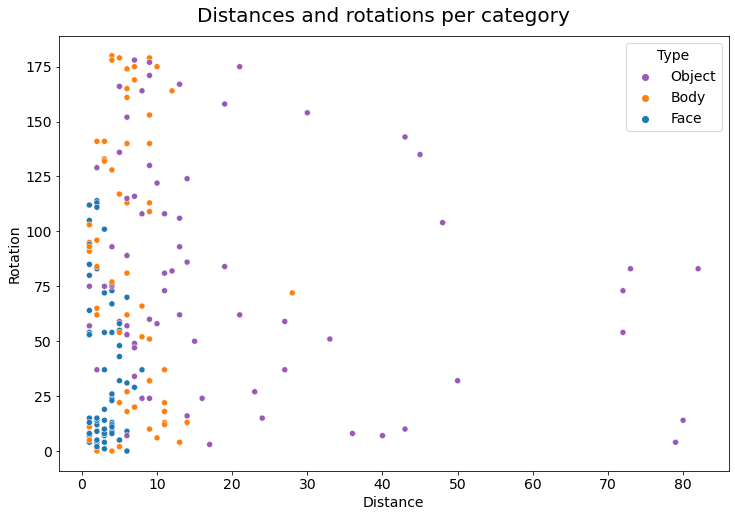

In [149]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots(figsize=(12,8))
plt.rcParams.update({'font.size': 14})
fig.suptitle("Distances and rotations per category", fontsize=20, y=0.93)
colors = dict(Object="#9b59b6", Face="#1f77b4", Body="#ff7f0e")
sns.scatterplot(data=df, x='Distance', y='Rotation', hue='Type', palette=colors)
ax.set_xlabel('Distance')
ax.set_ylabel('Rotation')
plt.savefig("data/images_statistics/" + "distances_rotations" + ".pdf", format='pdf', dpi=1200)

In [48]:
means = df.groupby('Type').mean()
means

,Rotation,Distance
Type,,
Body,76.957143,6.271429
Face,35.900000,3.014286
Object,79.714286,19.957143


/opt/anaconda3/envs/DefaultPython3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/envs/DefaultPython3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 10.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/DefaultPython3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/DefaultPython3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease 

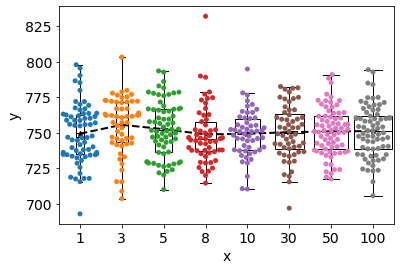

In [158]:
# fig, ax = plt.subplots(nrows=2, figsize=(10, 15), sharex=True)
#
# sns.boxplot(x='Type', y='Distance', palette=colors, hue='Type', data=df, ax=ax[0], dodge=False)
# ax[0].set_xlabel(None)
# sns.boxplot(x='Type', y='Rotation', palette=colors, data=df, ax=ax[1], dodge=False)


from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

df = pd.DataFrame({'x': np.random.choice([1, 3, 5, 8, 10, 30, 50, 100], 500),
                   'y': np.random.normal(750, 20, 500)})
xvals = np.unique(df.x)
positions = range(len(xvals))
plt.boxplot([df[df.x == xi].y for xi in xvals],
            positions=positions, showfliers=False,
            boxprops={'facecolor': 'none'}, medianprops={'color': 'black'}, patch_artist=True,
            widths=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
means = [np.mean(df[df.x == xi].y) for xi in xvals]
plt.plot(positions, means, '--k*', lw=2)
# plt.xticks(positions, xvals) # not needed anymore, as the xticks are set by the swarmplot
sns.swarmplot('x', 'y', data=df)
plt.show()

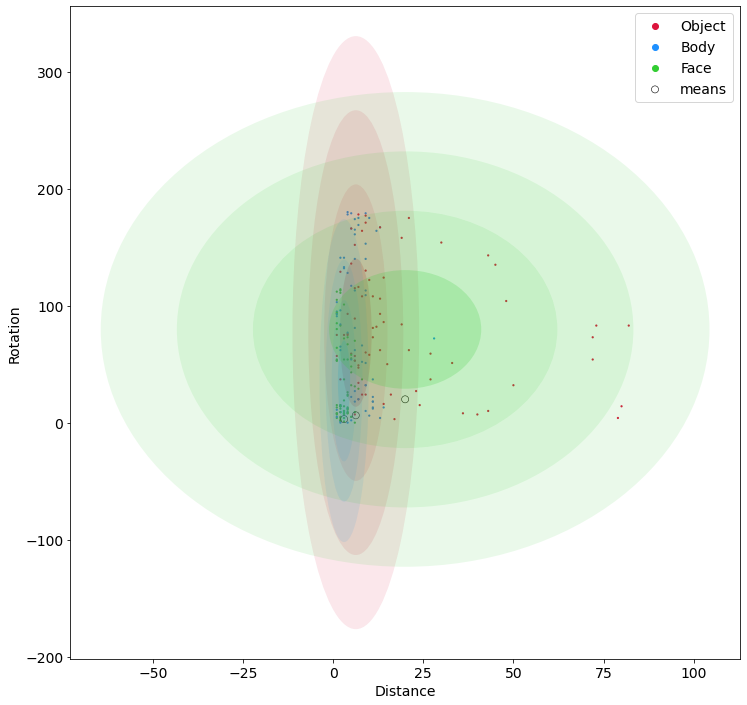

In [147]:
# K = 5
# N = 100
# df = pd.DataFrame({'X': np.random.normal(np.tile(np.random.uniform(10, 40, K), N), np.tile([3, 4, 7, 9, 10], N)),
#                    'Y': np.random.normal(np.tile(np.random.uniform(90, 500, K), N), np.tile([20, 25, 8, 22, 18], N)),
#                    'Bin': np.tile(np.arange(1, K + 1), N)})
# means = df.groupby('Type').mean()
# sdevs = df.groupby('Type').std()
#
# colors = ['crimson', 'dodgerblue', 'limegreen']
# fig, ax = plt.subplots(ncols=1, figsize=(12, 12))
# # for ax in axes:
# sns.scatterplot(x='Distance', y='Rotation', hue='Type', palette=colors, s=5, ec='none', data=df, ax=ax)
# sns.scatterplot(x='Distance', y='Distance', marker='o', s=50, fc='none', ec='black', label='means', data=means, ax=ax)
#     # if ax == axes[1]:
# for (_, mean), (_, sdev), color in zip(means.iterrows(), sdevs.iterrows(), colors):
#     for sdev_mult in [1, 2, 3, 4]:
#         ellipse = Ellipse((mean['Distance'], mean['Rotation']), width=2 * sdev['Distance'] * sdev_mult,
#                           height=2 * sdev['Rotation'] * sdev_mult,
#                           facecolor=color, alpha=0.2 if sdev_mult == 1 else 0.1)
#         ax.add_patch(ellipse)
# plt.show()

In [ ]:
# face_counts = df[df['Type']=='Face']['Hitname'].value_counts()
# body_counts = df[df['Type']=='Body']['Hitname'].value_counts()
# object_counts = df[df['Type']=='Object']['Hitname'].value_counts()

In [4]:
# df = df.groupby(['Type']).agg(sum = ('Object','Face','Body'))
res = df.groupby(['Type', 'Hitname']).agg(count=('Hitname', 'count'))
counts = res.reset_index()

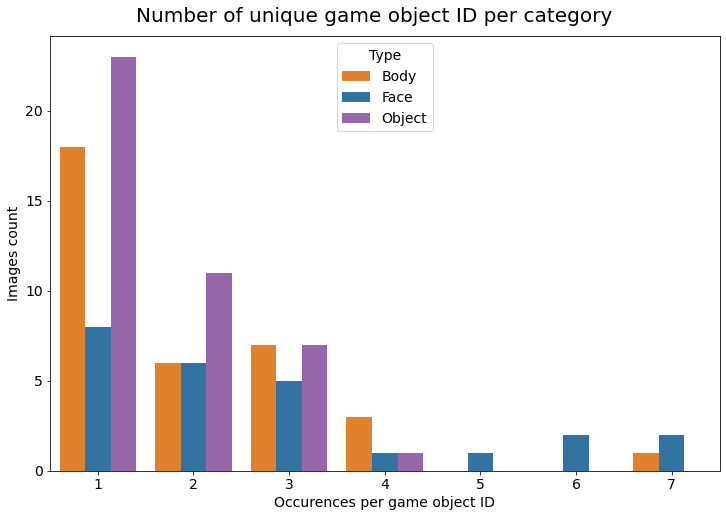

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
plt.rcParams.update({'font.size': 14})
fig.suptitle("Number of unique game object ID per category", fontsize=20, y=0.93)

sns.countplot(data=counts, x='count', hue='Type', palette=colors)
ax.set_xlabel('Occurences per game object ID')
ax.set_ylabel('Images count')
plt.savefig("data/images_statistics/" + "number_unique_game_object" + ".pdf", format='pdf', dpi=1200)

## TODOS
1. Change the repeated ID that differ but refer to the same object
* Some object ID's just vary in name although they refer to the same type of object (e.g, streetlight)

<AxesSubplot:xlabel='Count', ylabel='Hitname'>

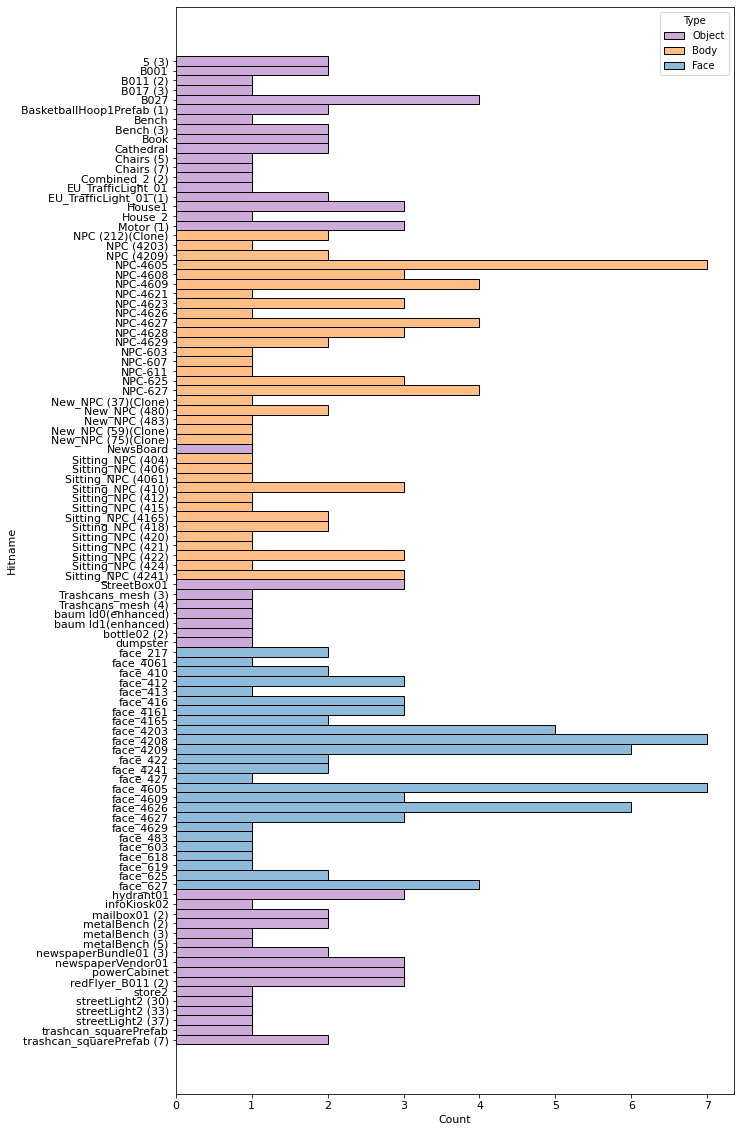

In [251]:
# count the times each unique object game ID repeats in the images dataset
fig, ax = plt.subplots(figsize=(10,20))
plt.rcParams.update({'font.size': 10})
df.sort_values(['Hitname'], inplace=True)
sns.histplot(data=df, y=df['Hitname'], hue='Type', palette=colors)

In [49]:
df.groupby(['Type']).mean()


,Rotation,Distance
Type,,
Body,76.957143,6.271429
Face,35.900000,3.014286
Object,79.714286,19.957143


AttributeError: 'Line2D' object has no property 'orient'

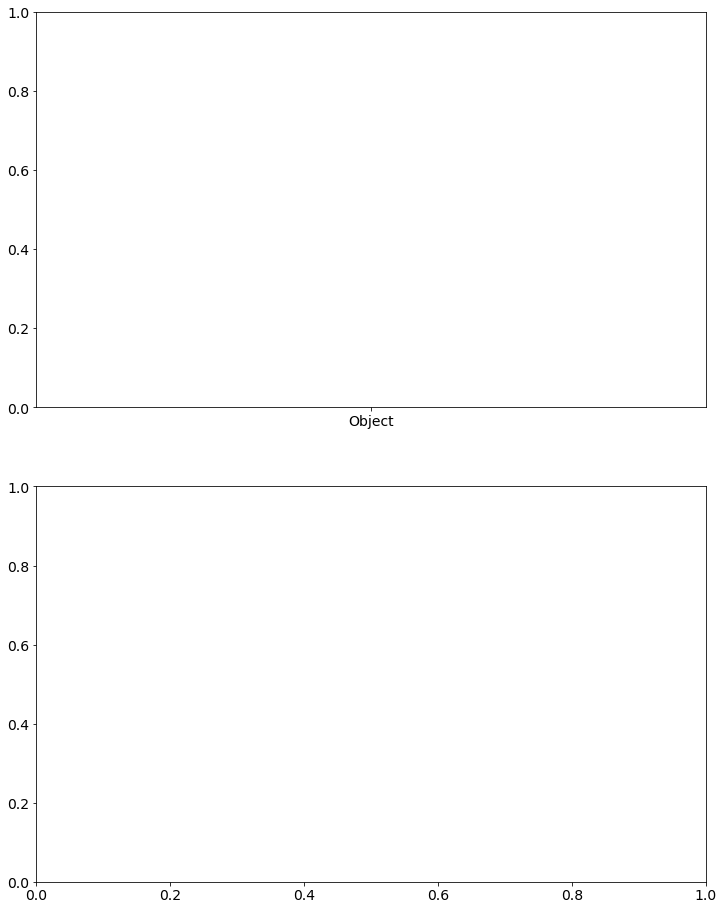

In [46]:
# calculating average distances and rotations per game object type
fig, ax = plt.subplots(2,1, figsize=(12,16))

sns.lineplot(x='Type', y='Distance', data=df, ax=ax[0], hue='Type', orient="y")
